In [1]:
!pip install -U fiona shapely pyproj rtree

!pip install -U geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
from pandas import read_csv, merge, concat
from geopandas import read_file, sjoin_nearest, GeoDataFrame, points_from_xy

from tqdm import tqdm
import geopandas as gpd

from zipfile import ZipFile

import json
from os import mkdir

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Colonias

cols = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/colonias_seduvi.zip').drop(columns='pob_2010') # Colonias CDMX
cols['area'] = cols.area.round(3)
cols['perimetro'] = cols.length.round(3)

In [6]:
datos = gpd.read_file('/content/drive/MyDrive/Colonias CDMX/Repositorio/Inventario_vivienda/data/base_shp/INV2020_IND_EU_FTE_09.shp').to_crs(cols.crs)

In [9]:
columnas = ['ALUMPUB', 'LETRERO','TELPUB','ARBOLES','SEMAPEAT','SEMAAUDI','PARATRAN','ESTABICI']

In [10]:
def invi(columnas):
    df = datos[['CVEGEO','geometry'] + columnas]

    for columna in columnas:
        df.loc[(df[columna].astype(str) == "3"), columna] = 0
        df.loc[(df[columna].astype(str) == "1"), columna] = 1
        df.loc[~(df[columna].isin([0,1])), columna] = 99

        df[columna] = df[columna].astype(int)

    df['cnt'] = df[columnas].sum(axis=1)
    df['cnt'] = df['cnt'].apply(lambda x: 1 if x < len(columnas)*99 else 0)
    df.query('cnt==1', inplace=True)

    df["geometry"] = df.geometry.representative_point()

    df_cols_join = gpd.sjoin_nearest(df, cols,
                                    distance_col='dist', how="left").query('dist<1500')

    df_cols = df_cols_join.groupby(['cve_col','colonia']).sum().reset_index()
    df_cols.drop(columns=['area','perimetro',
                        'index_right','dist'], inplace=True)

    df_cols_final = cols.merge(df_cols, on=['cve_col','colonia'], how='left').fillna(0)

    return df_cols_final.reset_index()

In [11]:
df_cols_final = invi(columnas)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-10-c1f564b7eaba>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [12]:
df_cols_final

,index,cve_ent,alcaldia,cve_col,colonia,area,perimetro,geometry,ALUMPUB,LETRERO,TELPUB,ARBOLES,SEMAPEAT,SEMAAUDI,PARATRAN,ESTABICI,cnt
0,0,09,AZCAPOTZALCO,02-001,AGUILERA,103824.818,1630.308,"POLYGON ((483311.618 2153254.848, 483332.006 2...",21.0,30.0,5.0,38.0,3.0,0.0,2.0,1.0,40.0
1,1,09,AZCAPOTZALCO,02-002,ALDANA,154811.632,1849.219,"POLYGON ((484406.956 2153012.331, 484401.132 2...",78.0,83.0,9.0,83.0,6.0,0.0,2.0,1.0,84.0
2,2,09,AZCAPOTZALCO,02-005,ANGEL ZIMBRON,242231.852,2188.456,"POLYGON ((480275.324 2152244.351, 480267.968 2...",43.0,46.0,10.0,56.0,14.0,0.0,3.0,1.0,62.0
3,3,09,AZCAPOTZALCO,02-006,ARENAL,286074.622,2154.409,"POLYGON ((484061.118 2152622.284, 484061.678 2...",101.0,105.0,18.0,134.0,11.0,0.0,1.0,0.0,160.0
4,4,09,AZCAPOTZALCO,02-007,CENTRO DE AZCAPOTZALCO,424470.637,3065.096,"POLYGON ((480104.707 2154525.214, 480118.178 2...",108.0,114.0,39.0,113.0,11.0,0.0,7.0,2.0,159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,1809,09,ALVARO OBREGON,10-236,VILLA PROGRESISTA,94022.465,1308.346,"POLYGON ((474406.945 2140353.439, 474418.850 2...",147.0,80.0,1.0,47.0,0.0,0.0,0.0,0.0,167.0
1810,1810,09,ALVARO OBREGON,10-237,VILLA SOLIDARIDAD,30095.479,1108.488,"POLYGON ((477054.695 2143212.991, 477044.798 2...",29.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,31.0
1811,1811,09,ALVARO OBREGON,10-238,VILLA VERDUN,641328.067,5953.245,"POLYGON ((473081.154 2138733.281, 473070.790 2...",13.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,13.0
1812,1812,09,ALVARO OBREGON,10-239,ZENON DELGADO,107450.727,1919.099,"POLYGON ((477329.014 2144260.214, 477335.725 2...",68.0,69.0,1.0,67.0,1.0,0.0,9.0,0.0,69.0


In [13]:
df_cols_final.to_file(f"/content/drive/MyDrive/Colonias CDMX/Repositorio/Inventario_vivienda/mobiliario_urbano/resultados/mobiliario_urbano.shp",
                   index=False)

Plot

In [14]:
df_cols_final_plot = df_cols_final.copy()
df_cols_final_plot['cnt'] = df_cols_final_plot['cnt'].apply(lambda x: 1 if x <= 0 else x)
df_cols_final_plot["new"] = (df_cols_final_plot["ALUMPUB"]/df_cols_final_plot["cnt"])*100

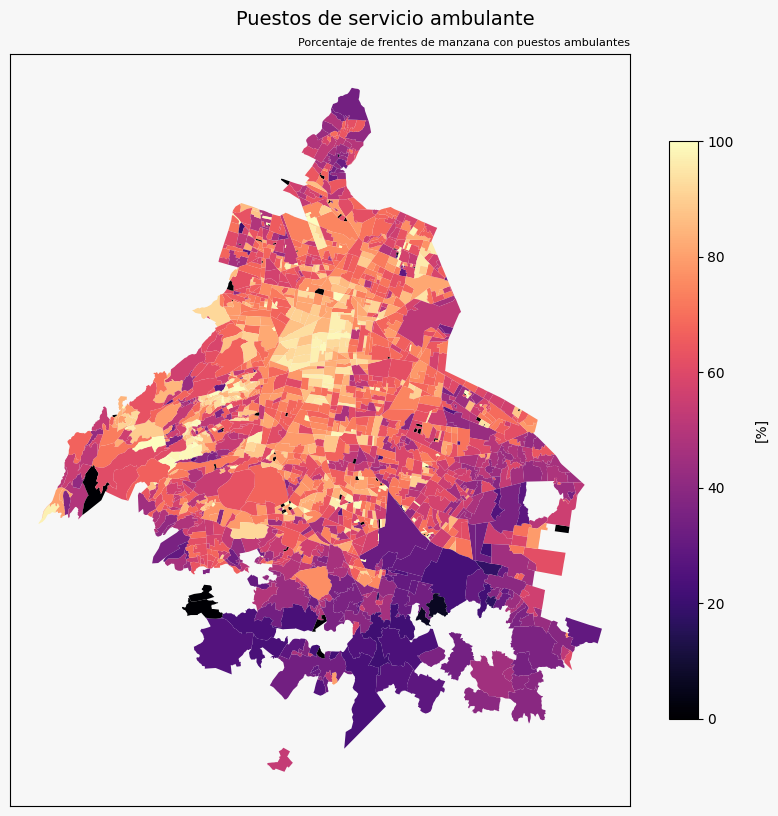

In [17]:
QAfig = plt.figure(figsize=(10, 15))

ax = df_cols_final_plot.plot(column='new', ax=plt.gca(),
                 cmap='magma', legend=True,
                 legend_kwds={"shrink": 0.5})



color_fondo = '#f7f7f7'
ax.set_facecolor(color_fondo)
QAfig.patch.set_facecolor(color_fondo)


ax.set_xticks([])
ax.set_yticks([])

plt.suptitle("Puestos de servicio ambulante", y=0.775, fontsize=14)
plt.title('Porcentaje de frentes de manzana con puestos ambulantes', loc='right', fontsize=8)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel('[%]', rotation=90, labelpad=15)

plt.savefig('/content/drive/MyDrive/Colonias CDMX/Repositorio/Inventario_vivienda/mobiliario_urbano/Ejemplo_mobiliario_urbano.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()